In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder #can't use without xtrain, ytrain
from fast_ml.feature_selection import get_constant_features
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df # y-> Exited-> Will the customer exit the bank or not

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# EDA

In [1]:
#ProfileReport(df) - Run in local system (Takes time and space)

# Summary from Profile 

1. Remove Row no., customer id, surname
2. Credit Score mean is very high, outliers might be present + little skewness is there.
3. Categorical -> Gender, Geography -> to numerical
4. skewness present in age
5. Tenure has zeroes -handle zeroes.
6. Mean(balance) is extremely high- outliers
7. Mean(estimated salary) is extremely high- outliers
8. Exited - imbalanced

# Pre-processing + feature engineering

## 1

In [5]:
df.shape

(10000, 14)

In [6]:
df.drop(columns = ['RowNumber','CustomerId','Surname'], axis = 1, inplace = True)
df.shape

(10000, 11)

In [7]:
df.isna().any()

CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

## 3

In [8]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [9]:
georgraphy_enc = df.groupby(['Geography'])['Exited'].mean()

In [10]:
georgraphy_enc

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64

In [11]:
georgraphy_enc = df.groupby(['Geography'])['Exited'].mean().to_dict()

In [12]:
georgraphy_enc

{'France': 0.16154766653370561,
 'Germany': 0.32443204463929853,
 'Spain': 0.1667339523617279}

In [13]:
df['Geography'] = df['Geography'].map(georgraphy_enc)

In [14]:
dfc = df.copy()

In [15]:
gender_enc = df.groupby(['Gender'])['Exited'].mean().to_dict()

In [16]:
gender_enc

{'Female': 0.2507153863086066, 'Male': 0.16455928165658787}

In [17]:
df['Gender'] = df['Gender'].map(gender_enc)

In [18]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
2,502,0.161548,0.250715,42,8,159660.80,3,1,0,113931.57,1
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0.161548,0.164559,39,5,0.00,2,1,0,96270.64,0
9996,516,0.161548,0.164559,35,10,57369.61,1,1,1,101699.77,0
9997,709,0.161548,0.250715,36,7,0.00,1,0,1,42085.58,1
9998,772,0.324432,0.164559,42,3,75075.31,2,1,0,92888.52,1


In [19]:
df['Geography'].value_counts()

0.161548    5014
0.324432    2509
0.166734    2477
Name: Geography, dtype: int64

# 5

In [20]:
len(df.loc[df['Tenure']==0])

413

In [21]:
df['Tenure'] = df['Tenure'].replace(0,int(df['Tenure'].mean()))

In [22]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
2,502,0.161548,0.250715,42,8,159660.80,3,1,0,113931.57,1
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0.161548,0.164559,39,5,0.00,2,1,0,96270.64,0
9996,516,0.161548,0.164559,35,10,57369.61,1,1,1,101699.77,0
9997,709,0.161548,0.250715,36,7,0.00,1,0,1,42085.58,1
9998,772,0.324432,0.164559,42,3,75075.31,2,1,0,92888.52,1


# 2+4+6+7

In [23]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

<AxesSubplot:>

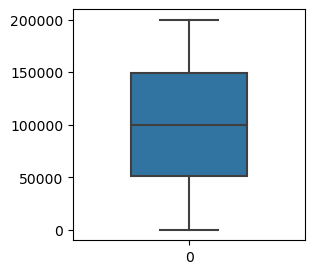

In [24]:
fig, ax = plt.subplots(figsize = (3,3))
sns.boxplot(data = df['EstimatedSalary'], width = 0.5, ax = ax, fliersize = 3)

In [25]:
df['NumOfProducts'].quantile(0.99)

3.0

In [26]:
df = df[df['CreditScore'] > df['CreditScore'].quantile(0.001)]

df = df[df['Age'] < df['Age'].quantile(0.95)]

df = df[df['NumOfProducts'] < df['NumOfProducts'].quantile(0.99)]

In [27]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0
5,645,0.166734,0.164559,44,8,113755.78,2,1,0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0.161548,0.164559,39,5,0.00,2,1,0,96270.64,0
9996,516,0.161548,0.164559,35,10,57369.61,1,1,1,101699.77,0
9997,709,0.161548,0.250715,36,7,0.00,1,0,1,42085.58,1
9998,772,0.324432,0.164559,42,3,75075.31,2,1,0,92888.52,1


# Extra steps

## Duplicated rows

In [28]:
df.duplicated().sum()

0

## Constant and Quasi Constant

In [29]:
get_constant_features(df)

,Desc,Var,Value,Perc


In [30]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0
5,645,0.166734,0.164559,44,8,113755.78,2,1,0,149756.71,1


In [31]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

## handling imbalanced dataset

In [32]:
df['Exited'].value_counts()

0    7542
1    1622
Name: Exited, dtype: int64

In [33]:
sm = SMOTETomek()
X_new, y_new = sm.fit_resample(X, y)

In [34]:
print('OG : ' + str(Counter(y)))
print('After Under Sampling : ' + str(Counter(y_new)))

OG : Counter({0: 7542, 1: 1622})
After Under Sampling : Counter({0: 6536, 1: 6536})


# Feature Selection

# Multi-Collinearity

In [35]:
std = StandardScaler()

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.75, random_state=23)

Xtrain = std.fit_transform(xtrain, ytrain)
Xtest = std.transform(xtest)

In [36]:
Xtrain.shape[1]

10

In [37]:
VIF = pd.DataFrame()
vif = variance_inflation_factor

In [38]:
VIF['VIF'] = [vif(Xtrain, i) for i in range(Xtrain.shape[1])]

In [39]:
VIF['Columns'] = X.columns

In [40]:
VIF # very very little multi-collinearity. Therefore, no use of taking any feature out. 

,VIF,Columns
0,1.001130,CreditScore
1,1.217670,Geography
2,1.003559,Gender
3,1.021850,Age
4,1.002184,Tenure
5,1.393846,Balance
6,1.189227,NumOfProducts
7,1.001182,HasCrCard
8,1.002940,IsActiveMember
9,1.000904,EstimatedSalary


# AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
ada = AdaBoostClassifier()

In [43]:
ada.fit(Xtrain,ytrain)
accuracy_score(ytest, ada.predict(Xtest))

0.8594500218245308

In [44]:
accuracy_score(ytest, ada.predict(Xtest))

0.8594500218245308

### Hyp tuning
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [45]:
params = { 'base_estimator' : [LogisticRegression(), LinearSVC(), RandomForestClassifier(), ExtraTreesClassifier(), None], 
           'n_estimators' : [1, 5, 10, 50, 100, 200], 
           'learning_rate' : [0.05, 0.1, 0.2, 0.3, 0.5, 1], 
        }

In [46]:
skfold = StratifiedKFold(5)

In [47]:
parameters = RandomizedSearchCV(ada, params, n_jobs = -1, verbose = 3, cv = skfold)

In [48]:
parameters.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'base_estimator': [LogisticRegression(),
                                                           LinearSVC(),
                                                           RandomForestClassifier(),
                                                           ExtraTreesClassifier(),
                                                           None],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5, 1],
                                        'n_estimators': [1, 5, 10, 50, 100,
                                                         200]},
                   verbose=3)

In [49]:
parameters.best_estimator_

AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.1,
                   n_estimators=5)

In [50]:
parameters.best_params_

{'n_estimators': 5,
 'learning_rate': 0.1,
 'base_estimator': RandomForestClassifier()}

In [51]:
clf = RandomForestClassifier()

In [52]:
params = { 'n_estimators' : [50, 100, 150, 200, 250, 300], 
           'criterion' : ['gini', 'entropy', 'log_loss'], 
           'max_depth' : range(2,30), 
           'min_samples_split' : range(2,30), 
           'min_samples_leaf' : range(2,30)
         }

In [53]:
rf_params = RandomizedSearchCV(clf, params, n_jobs = -1, verbose = 3, cv = skfold)

In [54]:
rf_params.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(2, 30),
                                        'min_samples_leaf': range(2, 30),
                                        'min_samples_split': range(2, 30),
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   verbose=3)

In [55]:
rf_params.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       min_samples_split=11)

In [56]:
rf = RandomForestClassifier(max_depth=23, min_samples_leaf=3, min_samples_split=19,n_estimators=50)

## Final prediction

In [57]:
ada_tuned = AdaBoostClassifier(base_estimator=rf, learning_rate=0.1)

In [62]:
feature_importance = ada_tuned.feature_importances_

In [63]:
feature_importance

array([0.19462823, 0.04048685, 0.02211398, 0.18413418, 0.09225757,
       0.17586942, 0.03808981, 0.02056805, 0.02582815, 0.20602376])

In [60]:
ada_tuned.fit(Xtrain,ytrain) #takes a lot of time

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=23,
                                                         min_samples_leaf=3,
                                                         min_samples_split=19,
                                                         n_estimators=50),
                   learning_rate=0.1)

In [61]:
accuracy_score(ytest, ada_tuned.predict(Xtest)) #takes a lot of time

0.8642514185945002

# GBM - very slow for larger datasets - use HistGBM instead of this for dataset >=10K

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()

In [65]:
gbm.fit(Xtrain, ytrain)
ypred = gbm.predict(Xtest)
accuracy_score(ytest, ypred)

0.870362287210825

### Hyp tuning

In [66]:
# best estimator not in GBM
params = {'learning_rate':[0.05, 0.1, 0.5, 1],
         'n_estimators': [50, 100, 150, 200, 250],
         'criterion':['friedman_mse', 'squared_error', 'mse'],
         'min_samples_split':range(2,20),
         'min_samples_leaf':range(2,20),
         'max_depth':range(1,30)}

In [67]:
gbm_par = RandomizedSearchCV(gbm, params, n_jobs = -1, cv = skfold, verbose = 10)

In [68]:
gbm_par.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse'],
                                        'learning_rate': [0.05, 0.1, 0.5, 1],
                                        'max_depth': range(1, 30),
                                        'min_samples_leaf': range(2, 20),
                                        'min_samples_split': range(2, 20),
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   verbose=10)

In [69]:
gbm_par.best_estimator_

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, min_samples_leaf=4,
                           min_samples_split=6, n_estimators=150)

In [70]:
new_gbm = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=2, min_samples_leaf=19,
                           min_samples_split=15, n_estimators=200)

In [71]:
new_gbm.fit(Xtrain, ytrain)
accuracy_score(ytest, new_gbm.predict(Xtest))

0.870362287210825

# XGB

In [72]:
clf = XGBClassifier()

In [73]:
clf.fit(Xtrain, ytrain)
accuracy_score(ytest, clf.predict(Xtest))

0.8555216062854648

### Hyp tuning

In [74]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
}

In [75]:
hyp=RandomizedSearchCV(clf,params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [76]:
hyp.fit(Xtrain, ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256,...
                                           max_leaves=0, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=0,
                                           reg_alpha=0, reg_lambda=1, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   verbose=3)

In [77]:
hyp.best_params_

{'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.25, 'gamma': 0.4}

In [78]:
hyp.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [79]:
xgb = XGBClassifier(objective='binary:logistic', min_child_weight= 3, max_depth= 3, learning_rate= 0.3, gamma= 0.5)
#same with and w/o objective

In [80]:
xgb.fit(xtrain, ytrain)
accuracy_score(ytest, xgb.predict(xtest))

0.8673068529026626